In [1]:
from extract import load_and_parse
skills = load_and_parse()

In [4]:
from config import cop_data

In [9]:
cop_data["events"][5]["eg"][3]

{'num': 4,
 'name': 'EG IV: Dismounts',
 'short': 'Dismounts',
 'page_range': [159, 161],
 'skills': {6: {'value': 'G', 'value_bbox': [0.45, 0.8, 0.65, 1]},
  54: {'value': 'G', 'value_box': [0.45, 0.8, 0.6, 0.92]},
  60: {'value': 'G', 'value_box': [0.45, 0.8, 0.6, 0.92]}}}

id: HB-4-60
event: Horizontal Bar
event_short: H-Bar
event_acronym: HB
eg: EG IV: Dismounts
eg_num: 4
box_num: 60
value: G
image_processed: 


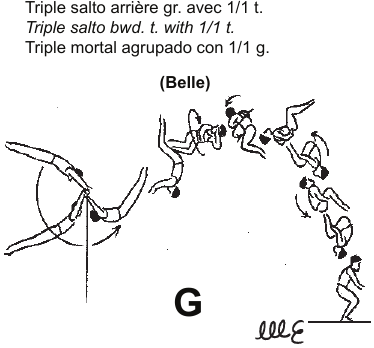

page: 160


In [3]:
import random
from PIL import Image
id = "HB-4-60"
skill = [sk for sk in skills if sk["id"] == id][0]
# skill = random.choice(skills)
num = skill["box_num"]
mask = [3, 0, 12*len(str(num)), 20]
for key, value in skill.items():
    if key.startswith("image"):
        if key == "image_processed":
            print(key + ": ")
            img = skill[key].copy()
            display(Image.fromarray(img))
    else:
        print(key + ": " + str(value))

{'id': 'HB-4-60', 'event': 'Horizontal Bar', 'event_short': 'H-Bar', 'event_acronym': 'HB', 'eg': 'EG IV: Dismounts', 'eg_num': 4, 'box_num': 60, 'value': 'G', 'image_filename': 'HB-4-60.png', 'image_raw': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [246, 246, 246],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        

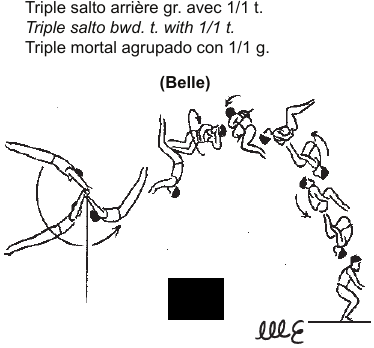

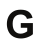

In [10]:
# Interface used to create the mask
from extract import masked_fill_pct 
import json
id = "HB-4-60"
with open("data/skills.json") as f:
    skills = json.load(f)
skill = [sk for sk in skills if sk["id"] == id][0]
fn = skill["image_filename"]

with open("data/img/masked/" + fn, "rb") as f:
    
    img = np.array()
img = skill["image_processed"]
mask = [0.45, 0.8, 0.6, 0.92]
x1_pct, y1_pct, x2_pct, y2_pct = mask
x1 = int(x1_pct * img.shape[1])
y1 = int(y1_pct * img.shape[0])
x2 = int(x2_pct * img.shape[1])
y2 = int(y2_pct * img.shape[0])
masked = masked_fill_pct(img.copy(), mask, 0)
cutout = img[y1:y2, x1:x2]
print(skill)
display(Image.fromarray(masked))
display(Image.fromarray(cutout))


In [1]:
from os import path
from pdf2image import convert_from_path
import cv2
import numpy as np
from PIL import Image
from config import cop_data

page_images = convert_from_path('en_ 2022-2024 MAG CoP.pdf', 200)

In [2]:
def render_borders(image, hlines, vlines):
    blank = np.zeros(image.shape, np.uint8) + 255
    for hline in hlines:
        start, end = hline
        blank[start:end, :] = 0
    for vline in vlines:
        start, end = vline
        blank[:, start:end] = 0
    return Image.fromarray(blank)

In [3]:
def get_borders(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a binary image
    _, binary = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)

    # Get the horizontal and vertical lines
    vsum = binary.sum(axis=0)
    hsum = binary.sum(axis=1)
    hlines = np.where(hsum < 0.4 * (hsum.max() - hsum.min()))[0]
    vlines = np.where(vsum < 0.4 * (vsum.max() - vsum.min()))[0]
    
    # Group adjacent lines into spans
    hline_spans = [];
    current = [];
    for i in range(0, len(hlines)):
        if len(current) == 0 or hlines[i] - current[-1] < 20:
            current.append(hlines[i])
        else:
            hline_spans.append([current[0], current[-1] + 1])
            current = [hlines[i]]
    hline_spans.append([current[0], current[-1] + 1])
    vline_spans = [];
    current = [];
    for i in range(0, len(vlines)):
        if len(current) == 0 or vlines[i] - current[-1] < 10:
            current.append(vlines[i])
        else:
            vline_spans.append([current[0], current[-1] + 1])
            current = [vlines[i]]
    vline_spans.append([current[0], current[-1] + 1])

    return hline_spans[1:], vline_spans

# test the function
for event in cop_data["events"]:
    for eg in event["eg"]:
        first, last = eg["page_range"]
        for page_num in range(first, last + 1):
            page = page_images[page_num - 1]
            hlines, vlines = get_borders(np.array(page))
            assert len(hlines) == 5
            assert len(vlines) == 7

In [4]:
def get_boxes(page):
    hlines, vlines = get_borders(page)
    imgs = []
    for i in range(1, len(hlines)):
        for j in range(1, len(vlines)):
            y1 = hlines[i-1][1]
            y2 = hlines[i][0]
            x1 = vlines[j-1][1]
            x2 = vlines[j][0]
            img = page[y1:y2, x1:x2]
            imgs.append(img)

    img_sums = [img.sum() for img in imgs]
    threshold = np.mean(img_sums) #+ 0.2 * np.std(img_sums)
    return [{ "img": img, "is_empty": img.sum() > threshold } for img in imgs]
    

In [5]:
def masked_fill_pct(img, box_pct, color=255):
    x1_pct, y1_pct, x2_pct, y2_pct = box_pct
    x1 = int(x1_pct * img.shape[1])
    y1 = int(y1_pct * img.shape[0])
    x2 = int(x2_pct * img.shape[1])
    y2 = int(y2_pct * img.shape[0])
    img[y1:y2, x1:x2] = color
    return img

In [100]:

skills = []
values = "ABCDEF"
for event in cop_data["events"]:
    for egr in event["eg"]:
        if event["acronym"] == "VT":
            box_num = 100 * egr["num"]
        else:
            box_num = 0;
        first, last = egr["page_range"]
        for p in range(first - 1, last):
            page_arr = np.array(page_images[p])
            for box in get_boxes(page_arr):
                box_num += 1
                if (box["is_empty"]):
                    continue
                id = event["acronym"] + "-" + str(egr["num"]) + "-" + str(box_num)
                filename = id + ".png"

                img_proc = box["img"].copy()
                skill = egr.get("skills", {}).get(box_num, {})
                # mask out the value
                value_bbox = skill.get("value_bbox")
                if (value_bbox):
                    masked_fill_pct(img_proc, value_bbox)
                # mask out the box number
                mask = [0, 0, 12*len(str(box_num)), 20]
                x1, y1, x2, y2 = mask
                img_proc[y1:y2, x1:x2] = 255

                value = skill.get("value") or values[(box_num - 1) % len(values)]
                skills.append({
                    "id": id,
                    "event": event["name"],
                    "event_short": event["short"],
                    "event_acronym": event["acronym"],
                    "eg": egr["name"],
                    "eg_num": egr["num"],
                    "box_num": box_num,
                    "value": value,
                    "image_filename": filename,
                    "image_raw": box["img"],
                    "image_processed": img_proc,
                    "page": p,
                })
                # todo: remove the number from top left corner
                # todo/maybe: resize the image to 32x32
                # cv2.imwrite(path.join(img_dir_proc, filename), box)

In [106]:
import json
from copy import deepcopy
persisted_skills = deepcopy(skills)
img_dir_raw = "data/img/raw/"
img_dir_proc = "data/img/masked/"
for skill in persisted_skills:
    cv2.imwrite(path.join(img_dir_raw, skill["image_filename"]), skill["image_raw"])
    cv2.imwrite(path.join(img_dir_proc, skill["image_filename"]), skill["image_processed"])
    del skill["image_raw"]
    del skill["image_processed"]
with open("data/skills.json", "w") as f:
    json.dump(persisted_skills, f, indent=2)

In [31]:
len(str(110))

3

id: FX-3-41
event: Floor Exercise
event_short: Floor
event_acronym: FX
eg: EG III: Acrobatic elements backward
eg_num: 3
box_num: 41
value: E
image_processed: 


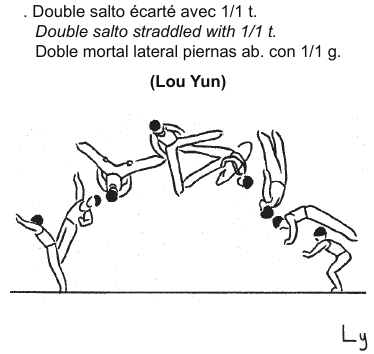

page: 51


In [105]:
import random
# id = "FX-1-10"
# skill = [sk for sk in skills if sk["id"] == id][0]
skill = random.choice(skills)
num = skill["box_num"]
mask = [3, 0, 12*len(str(num)), 20]
for key, value in skill.items():
    if key.startswith("image"):
        if key == "image_processed":
            print(key + ": ")
            img = skill[key].copy()
            display(Image.fromarray(img))
    else:
        print(key + ": " + str(value))

In [33]:
# Interface used to create the mask
# id = "VT-1-101"
# skill = [sk for sk in skills if sk["id"] == id][0]
# img = skill["image_processed"]
# mask = [0, 0.9, 0.3, 1]
# x1_pct, y1_pct, x2_pct, y2_pct = mask
# x1 = int(x1_pct * img.shape[1])
# y1 = int(y1_pct * img.shape[0])
# x2 = int(x2_pct * img.shape[1])
# y2 = int(y2_pct * img.shape[0])
# masked = masked_fill_pct(img.copy(), mask, 0)
# cutout = img[y1:y2, x1:x2]
# print(skill)
# display(Image.fromarray(masked))
# display(Image.fromarray(cutout))